# ***Global Warming - Analysis of Forest Cover based on Temperature***

<br />
<center>
<img src =ipynb.images/globalwarming.gif width = 400 />
</center>

In [13]:
import pandas as pd
from pandas import DataFrame
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline



# **Data Loading and Cleaning**

Emissions data and removing all null values 

In [14]:
ForestCover_df = pd.read_csv('C:/Users/shali/Desktop/DS Final/climate_data.csv')

ForestCover_df.dropna()


,Date,Solar Radiation,UV radiation,Highest Infrared radiation,Air temperature,N2O level,Antarctic mass(Gigatonnes),Antarctic mass 1-sigma uncertainty,DETER
0,2010-01,171.46,10.24,346.41,7.43,323.70,-803.23,33.03,23
1,2010-02,216.36,16.83,360.59,8.83,323.85,-807.45,32.76,185
2,2010-03,268.88,29.48,382.27,11.67,323.94,-688.18,34.51,52
3,2010-04,320.56,43.18,408.13,14.50,324.08,-759.94,32.20,52
4,2010-05,404.24,56.52,439.41,18.38,323.85,-780.91,32.63,110
...,...,...,...,...,...,...,...,...,...
115,2019-08,411.59,61.49,531.08,30.90,331.72,-2228.62,31.57,1695
116,2019-09,342.24,42.89,482.35,25.32,331.84,-2100.59,32.60,1443
117,2019-10,367.58,27.95,413.16,16.54,332.03,-2281.08,33.45,555
118,2019-11,256.04,15.22,374.80,12.37,332.38,-2341.65,39.41,523


<br />
<center>
<img src =ipynb.images/def.gif width = 400 />
</center>

making 'Date' column as index

In [15]:
ForestCover_df.Date = pd.to_datetime(ForestCover_df.Date)
ForestCover_df = ForestCover_df.set_index('Date')
ForestCover_df.head(10)

,Solar Radiation,UV radiation,Highest Infrared radiation,Air temperature,N2O level,Antarctic mass(Gigatonnes),Antarctic mass 1-sigma uncertainty,DETER
Date,,,,,,,,
2010-01-01,171.46,10.24,346.41,7.43,323.70,-803.23,33.03,23
2010-02-01,216.36,16.83,360.59,8.83,323.85,-807.45,32.76,185
2010-03-01,268.88,29.48,382.27,11.67,323.94,-688.18,34.51,52
2010-04-01,320.56,43.18,408.13,14.50,324.08,-759.94,32.20,52
2010-05-01,404.24,56.52,439.41,18.38,323.85,-780.91,32.63,110
2010-06-01,436.70,69.21,495.04,27.64,323.73,-794.11,38.44,244
2010-07-01,399.97,68.43,524.21,32.51,323.66,-998.22,35.63,485
2010-08-01,438.29,60.29,524.21,32.51,323.47,-927.15,34.62,265
2010-09-01,408.54,46.55,473.62,26.35,323.49,-848.74,36.40,448


The Amazon rainforest has long been recognized as a repository of ecological services not only for local tribes and communities, but also for the rest of the world. It is also the only rainforest that we have left in terms of size and diversity.Brazil holds about one-third of the world's remaining rainforests, including a majority of the Amazon rainforest.


<br />
<center>
<img src =ipynb.images/amazon.gif width = 400 />
</center>

Copying original DataFrame and taking only column **'DETER'- Deforestation Detection of Amazon Forest in sq km**

Final DataFrame for deforestation prediction

In [16]:
f_ForestCover_df=ForestCover_df[['DETER']].copy()
f_ForestCover_df


,DETER
Date,
2010-01-01,23
2010-02-01,185
2010-03-01,52
2010-04-01,52
2010-05-01,110
...,...
2019-08-01,1695
2019-09-01,1443
2019-10-01,555


**Data Visualisation**

Plotting the Monthly Deforestation from 2010-2019 in sq km 

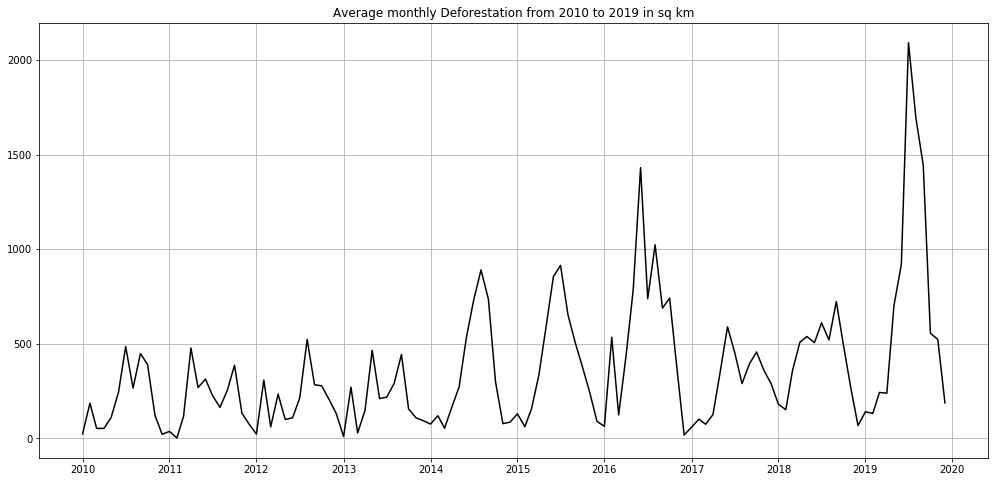

In [17]:
plt.figure(figsize=(17, 8))
plt.plot(f_ForestCover_df.index,f_ForestCover_df['DETER'],color='black')
plt.title('Average monthly Deforestation from 2010 to 2019 in sq km')
plt.grid(True)


# Now starts the prediction analytics on the final data


1. Run RNN-LSTM on the independant features we have on data from 2010-2019
2. Test the values with 2019 data
3. Once we reach model accuracy greater than 95% we then have to extrapolate the index into the future i.e.2020
4. Now we have independant feature values(DETER) for the future(2020)
5. Finally we predict the Air Temperature of the future using these values

<br />
<center>
<img src =ipynb.images/model.gif width = 400 />
</center>

In [18]:
train, test =f_ForestCover_df[:-12], f_ForestCover_df[-12:]

In [19]:
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

**LSTM Model** - Long Short Term Memory model is a type supervised Deep Neural Network that is very good at doing time-series prediction. It is a type of RNN (Recurrent Neural Network). An LSTM model looks at last “n” days(timestep) data (also called lag) and predicts how the series can progress in the future.**

In [20]:
n_input = 12
n_features = 1

generator = TimeseriesGenerator(train, train, length = n_input , batch_size=6)

model = Sequential()
model.add(LSTM(100, activation ='relu', input_shape = (n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')
model.fit_generator(generator,epochs=600)

Epoch 1/600
16/16 [==============================] - 0s 7ms/step - loss: 0.0491
Epoch 2/600
16/16 [==============================] - 0s 6ms/step - loss: 0.0319
Epoch 3/600
16/16 [==============================] - 0s 5ms/step - loss: 0.0321
Epoch 4/600
16/16 [==============================] - 0s 9ms/step - loss: 0.0306
Epoch 5/600
16/16 [==============================] - 0s 6ms/step - loss: 0.0297
Epoch 6/600
16/16 [==============================] - 0s 6ms/step - loss: 0.0308
Epoch 7/600
16/16 [==============================] - 0s 6ms/step - loss: 0.0277
Epoch 8/600
16/16 [==============================] - 0s 7ms/step - loss: 0.0285
Epoch 9/600
16/16 [==============================] - 0s 5ms/step - loss: 0.0292
Epoch 10/600
16/16 [==============================] - 0s 7ms/step - loss: 0.0268
Epoch 11/600
16/16 [==============================] - 0s 5ms/step - loss: 0.0269
Epoch 12/600
16/16 [==============================] - 0s 6ms/step - loss: 0.0265
Epoch 13/600
16/16 [=================

Epoch 102/600
16/16 [==============================] - 0s 6ms/step - loss: 0.0125
Epoch 103/600
16/16 [==============================] - 0s 6ms/step - loss: 0.0119
Epoch 104/600
16/16 [==============================] - 0s 6ms/step - loss: 0.0120
Epoch 105/600
16/16 [==============================] - 0s 6ms/step - loss: 0.0141
Epoch 106/600
16/16 [==============================] - 0s 6ms/step - loss: 0.0139
Epoch 107/600
16/16 [==============================] - 0s 6ms/step - loss: 0.0152
Epoch 108/600
16/16 [==============================] - 0s 6ms/step - loss: 0.0146
Epoch 109/600
16/16 [==============================] - 0s 7ms/step - loss: 0.0131
Epoch 110/600
16/16 [==============================] - 0s 6ms/step - loss: 0.0127
Epoch 111/600
16/16 [==============================] - 0s 6ms/step - loss: 0.0138
Epoch 112/600
16/16 [==============================] - 0s 6ms/step - loss: 0.0125
Epoch 113/600
16/16 [==============================] - 0s 6ms/step - loss: 0.0142
Epoch 114/600
16

Epoch 301/600
16/16 [==============================] - 0s 7ms/step - loss: 0.0070
Epoch 302/600
16/16 [==============================] - 0s 7ms/step - loss: 0.0079
Epoch 303/600
16/16 [==============================] - 0s 7ms/step - loss: 0.0048
Epoch 304/600
16/16 [==============================] - 0s 7ms/step - loss: 0.0076
Epoch 305/600
16/16 [==============================] - 0s 8ms/step - loss: 0.0081
Epoch 306/600
16/16 [==============================] - 0s 10ms/step - loss: 0.0065
Epoch 307/600
16/16 [==============================] - 0s 8ms/step - loss: 0.0050
Epoch 308/600
16/16 [==============================] - 0s 8ms/step - loss: 0.0057
Epoch 309/600
16/16 [==============================] - 0s 7ms/step - loss: 0.0044
Epoch 310/600
16/16 [==============================] - 0s 7ms/step - loss: 0.0063
Epoch 311/600
16/16 [==============================] - 0s 7ms/step - loss: 0.0054
Epoch 312/600
16/16 [==============================] - 0s 8ms/step - loss: 0.0049
Epoch 313/600
1

16/16 [==============================] - 0s 9ms/step - loss: 0.0029
Epoch 500/600
16/16 [==============================] - 0s 8ms/step - loss: 0.0045
Epoch 501/600
16/16 [==============================] - 0s 8ms/step - loss: 0.0033
Epoch 502/600
16/16 [==============================] - 0s 8ms/step - loss: 0.0033
Epoch 503/600
16/16 [==============================] - 0s 8ms/step - loss: 0.0047
Epoch 504/600
16/16 [==============================] - 0s 8ms/step - loss: 0.0044
Epoch 505/600
16/16 [==============================] - 0s 8ms/step - loss: 0.0036
Epoch 506/600
16/16 [==============================] - 0s 8ms/step - loss: 0.0031
Epoch 507/600
16/16 [==============================] - 0s 8ms/step - loss: 0.0030
Epoch 508/600
16/16 [==============================] - 0s 8ms/step - loss: 0.0029
Epoch 509/600
16/16 [==============================] - 0s 9ms/step - loss: 0.0028
Epoch 510/600
16/16 [==============================] - 0s 9ms/step - loss: 0.0028
Epoch 511/600
16/16 [=========

In [21]:
pred_list = []
batch = train[-n_input:].reshape((1,n_input,n_features))

for i in range(n_input):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:, 1:,:], [[pred_list[i]]], axis=1)

In [22]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index = f_ForestCover_df[-n_input:].index,columns=['Predictions'])

df_test = pd.concat([f_ForestCover_df, df_predict], axis=1)

In [23]:
df_test.tail(13)

,DETER,Predictions
Date,,
2018-12-01,67,NaN
2019-01-01,140,370.292298
2019-02-01,131,244.435912
2019-03-01,242,316.130797
2019-04-01,238,359.190827
2019-05-01,702,539.917930
2019-06-01,919,544.876199
2019-07-01,2092,520.754284
2019-08-01,1695,707.046399


**Comparing existing and predicted data for the year 2019**

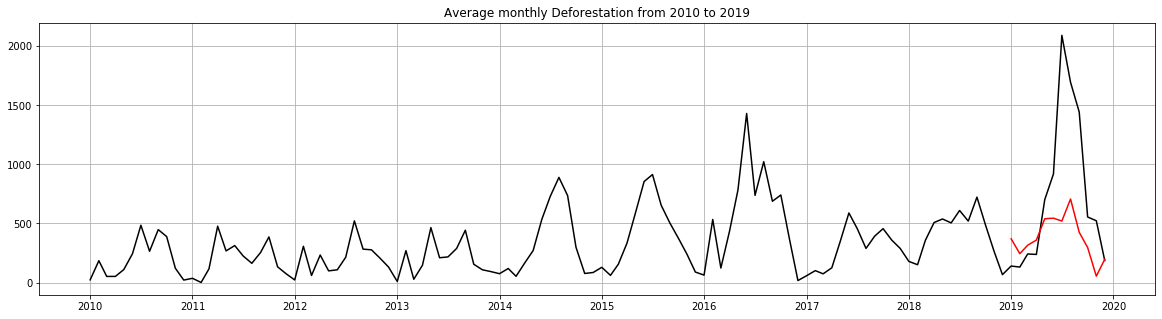

In [24]:
plt.figure(figsize=(20, 5))
plt.plot(df_test.index,df_test['DETER'],color='black')
plt.plot(df_test.index, df_test['Predictions'],color = 'r')
plt.title('Average monthly Deforestation from 2010 to 2019')
plt.grid(True)

**Now predicting for the future year 2020 based on past years(2010-2019)**

In [25]:
train = f_ForestCover_df

scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)

n_input = 12
n_features = 1

generator = TimeseriesGenerator(train, train, length = n_input , batch_size=6)
model.fit_generator(generator,epochs=400)


Epoch 1/400
18/18 [==============================] - 0s 7ms/step - loss: 0.0113
Epoch 2/400
18/18 [==============================] - 0s 6ms/step - loss: 0.0082
Epoch 3/400
18/18 [==============================] - 0s 6ms/step - loss: 0.0070
Epoch 4/400
18/18 [==============================] - 0s 6ms/step - loss: 0.0067
Epoch 5/400
18/18 [==============================] - 0s 7ms/step - loss: 0.0062
Epoch 6/400
18/18 [==============================] - 0s 7ms/step - loss: 0.0067
Epoch 7/400
18/18 [==============================] - 0s 8ms/step - loss: 0.0064
Epoch 8/400
18/18 [==============================] - 0s 8ms/step - loss: 0.0087
Epoch 9/400
18/18 [==============================] - 0s 8ms/step - loss: 0.0059
Epoch 10/400
18/18 [==============================] - 0s 8ms/step - loss: 0.0045
Epoch 11/400
18/18 [==============================] - 0s 7ms/step - loss: 0.0052
Epoch 12/400
18/18 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 13/400
18/18 [=================

18/18 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 202/400
18/18 [==============================] - 0s 7ms/step - loss: 0.0010
Epoch 203/400
18/18 [==============================] - 0s 7ms/step - loss: 0.0014
Epoch 204/400
18/18 [==============================] - 0s 7ms/step - loss: 9.1151e-04
Epoch 205/400
18/18 [==============================] - 0s 7ms/step - loss: 0.0010
Epoch 206/400
18/18 [==============================] - 0s 7ms/step - loss: 9.2469e-04
Epoch 207/400
18/18 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 208/400
18/18 [==============================] - 0s 7ms/step - loss: 7.8262e-04
Epoch 209/400
18/18 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 210/400
18/18 [==============================] - 0s 7ms/step - loss: 8.7980e-04
Epoch 211/400
18/18 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 212/400
18/18 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 213/400


18/18 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 396/400
18/18 [==============================] - 0s 8ms/step - loss: 5.8358e-04
Epoch 397/400
18/18 [==============================] - 0s 8ms/step - loss: 6.7522e-04
Epoch 398/400
18/18 [==============================] - 0s 8ms/step - loss: 6.5683e-04
Epoch 399/400
18/18 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 400/400
18/18 [==============================] - 0s 8ms/step - loss: 0.0010


**Adding index as a year for 2020 for the future data**

In [26]:
from pandas.tseries.offsets import DateOffset
add_dates = [f_ForestCover_df.index[-1] + DateOffset(months=x) for x in range(0,13)]
future_dates = pd.DataFrame(index=add_dates[1:],columns=f_ForestCover_df.columns)


In [27]:
future_dates.tail(12)

,DETER
2020-01-01,NaN
2020-02-01,NaN
2020-03-01,NaN
2020-04-01,NaN
2020-05-01,NaN
2020-06-01,NaN
2020-07-01,NaN
2020-08-01,NaN
2020-09-01,NaN
2020-10-01,NaN


**Prediction for the year 2020**

In [28]:
prediction = []
batch = train[-n_input:].reshape((1,n_input,n_features))

for i in range(n_input):
    prediction.append(model.predict(batch)[0])
    batch = np.append(batch[:, 1:,:], [[prediction[i]]], axis=1)

In [29]:

prediction = pd.DataFrame(scaler.inverse_transform(prediction), index=future_dates[-n_input:].index, columns=['Prediction'])

In [30]:
final_df = pd.concat([f_ForestCover_df,prediction],axis=1)
final_df.tail(14)

,DETER,Prediction
2019-11-01,523.0,NaN
2019-12-01,187.0,NaN
2020-01-01,NaN,87.303319
2020-02-01,NaN,54.174818
2020-03-01,NaN,2.223961
2020-04-01,NaN,11.242163
2020-05-01,NaN,113.640822
2020-06-01,NaN,437.015217
2020-07-01,NaN,1209.236333
2020-08-01,NaN,1174.449306


**Plotted future prediction of Deforestation data**

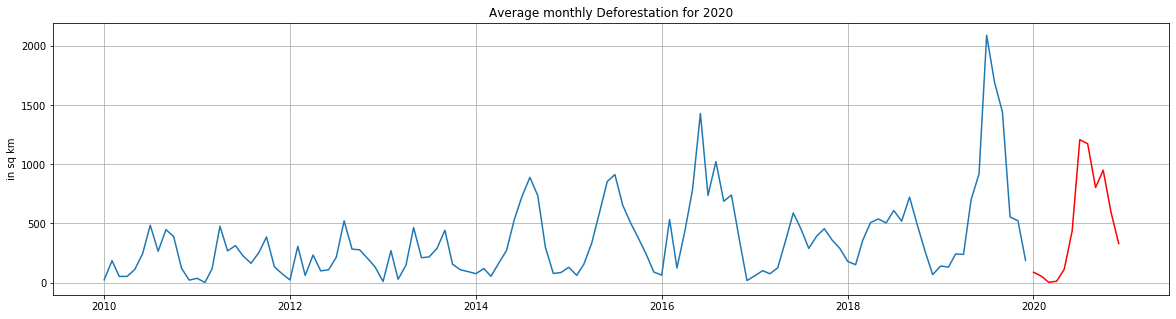

In [31]:
plt.figure(figsize=(20, 5))
plt.plot(final_df.index, final_df['DETER'])
plt.plot(final_df.index, final_df['Prediction'], color='r')
plt.title('Average monthly Deforestation for 2020')
plt.ylabel('in sq km')
plt.grid(True)

In [33]:
future_deforestation =pd.concat([f_ForestCover_df,prediction.rename(columns={'Prediction':'DETER'})])
future_deforestation.tail(13)

,DETER
2019-12-01,187.000000
2020-01-01,87.303319
2020-02-01,54.174818
2020-03-01,2.223961
2020-04-01,11.242163
2020-05-01,113.640822
2020-06-01,437.015217
2020-07-01,1209.236333
2020-08-01,1174.449306
2020-09-01,804.160869


**Filtering Air Temperature column from the original dataframe and combining Deforestation and Temperature columns**

In [34]:
air_temp=pd.DataFrame(ForestCover_df['Air temperature'])
air_temp.index=pd.to_datetime(air_temp.index)
future_deforestation1=pd.concat([future_deforestation,air_temp],axis=1)

In [35]:
future_deforestation1.tail(14)

,DETER,Air temperature
2019-11-01,523.000000,12.37
2019-12-01,187.000000,6.45
2020-01-01,87.303319,NaN
2020-02-01,54.174818,NaN
2020-03-01,2.223961,NaN
2020-04-01,11.242163,NaN
2020-05-01,113.640822,NaN
2020-06-01,437.015217,NaN
2020-07-01,1209.236333,NaN
2020-08-01,1174.449306,NaN


***Now lets predict the future Air temperatures using the deforestations data(past and predicted) ***

Taking Air Temperature column from the dataframe

In [37]:
air_temp=pd.DataFrame(future_deforestation1['Air temperature'])
air_temp

,Air temperature
2010-01-01,7.43
2010-02-01,8.83
2010-03-01,11.67
2010-04-01,14.50
2010-05-01,18.38
...,...
2020-08-01,NaN
2020-09-01,NaN
2020-10-01,NaN
2020-11-01,NaN


Testing on present data of deforestation and Temperature

In [38]:
X_train,X_test, Y_train, Y_test=future_deforestation[:-24],future_deforestation[-24:-12],air_temp[:-24],air_temp[-24:-12]
scaler= MinMaxScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)
scaler.fit(Y_train)
Y_train=scaler.transform(Y_train)
Y_test=scaler.transform(Y_test)

In [39]:
len(ForestCover_df ['Air temperature'])

120

In [40]:
from keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

***For temperature we took ANN model with Adam optimizer as it's working good on temperature***

In [44]:
#K.clear_session()
model = Sequential()
model.add(Dense(50, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.add(Dense(50, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, Y_train, batch_size=6, epochs=400, verbose=1)

Epoch 1/400
108/108 [==============================] - 0s 64us/step - loss: 0.1015
Epoch 2/400
108/108 [==============================] - 0s 65us/step - loss: 0.0691
Epoch 3/400
108/108 [==============================] - 0s 55us/step - loss: 0.0591
Epoch 4/400
108/108 [==============================] - 0s 92us/step - loss: 0.0532
Epoch 5/400
108/108 [==============================] - 0s 55us/step - loss: 0.0508
Epoch 6/400
108/108 [==============================] - 0s 46us/step - loss: 0.0498
Epoch 7/400
108/108 [==============================] - 0s 120us/step - loss: 0.0490
Epoch 8/400
108/108 [==============================] - 0s 55us/step - loss: 0.0480
Epoch 9/400
108/108 [==============================] - 0s 65us/step - loss: 0.0467
Epoch 10/400
108/108 [==============================] - 0s 55us/step - loss: 0.0475
Epoch 11/400
108/108 [==============================] - 0s 92us/step - loss: 0.0453
Epoch 12/400
108/108 [==============================] - 0s 55us/step - loss: 0.0466


108/108 [==============================] - 0s 102us/step - loss: 0.0428
Epoch 195/400
108/108 [==============================] - 0s 83us/step - loss: 0.0441
Epoch 196/400
108/108 [==============================] - 0s 83us/step - loss: 0.0444
Epoch 197/400
108/108 [==============================] - 0s 102us/step - loss: 0.0434
Epoch 198/400
108/108 [==============================] - 0s 92us/step - loss: 0.0435
Epoch 199/400
108/108 [==============================] - 0s 83us/step - loss: 0.0430
Epoch 200/400
108/108 [==============================] - 0s 120us/step - loss: 0.0431
Epoch 201/400
108/108 [==============================] - 0s 111us/step - loss: 0.0439
Epoch 202/400
108/108 [==============================] - 0s 102us/step - loss: 0.0429
Epoch 203/400
108/108 [==============================] - 0s 83us/step - loss: 0.0440
Epoch 204/400
108/108 [==============================] - 0s 111us/step - loss: 0.0430
Epoch 205/400
108/108 [==============================] - 0s 111us/step - 

108/108 [==============================] - 0s 102us/step - loss: 0.0431
Epoch 386/400
108/108 [==============================] - 0s 65us/step - loss: 0.0421
Epoch 387/400
108/108 [==============================] - 0s 92us/step - loss: 0.0425
Epoch 388/400
108/108 [==============================] - 0s 74us/step - loss: 0.0426
Epoch 389/400
108/108 [==============================] - 0s 102us/step - loss: 0.0418
Epoch 390/400
108/108 [==============================] - 0s 65us/step - loss: 0.0417
Epoch 391/400
108/108 [==============================] - 0s 74us/step - loss: 0.0428
Epoch 392/400
108/108 [==============================] - 0s 92us/step - loss: 0.0423
Epoch 393/400
108/108 [==============================] - 0s 74us/step - loss: 0.0426
Epoch 394/400
108/108 [==============================] - 0s 102us/step - loss: 0.0420
Epoch 395/400
108/108 [==============================] - 0s 74us/step - loss: 0.0433
Epoch 396/400
108/108 [==============================] - 0s 111us/step - los

**Plot the present and predicted Air temperature**

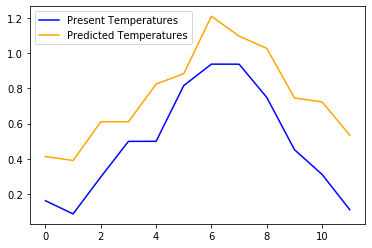

In [48]:
y_pred = model.predict(X_test)

plt.plot(Y_test,label = 'Present Temperatures',color='blue')
plt.plot(y_pred,label = 'Predicted Temperatures',color='orange')
plt.legend(loc='best')


**Now predicting future temperature(2020) based on future deforestation data(2020)**

In [49]:
X_train,X_test, Y_train, Y_test=future_deforestation[:-12],future_deforestation[-12:],air_temp[:-12],air_temp[-12:]
scaler= MinMaxScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)
scaler.fit(Y_train)
Y_train=scaler.transform(Y_train)
Y_test=scaler.transform(Y_test)

In [50]:
model.fit(X_train, Y_train, batch_size=16, epochs=600, verbose=1)

Epoch 1/600
120/120 [==============================] - 0s 58us/step - loss: 0.0483
Epoch 2/600
120/120 [==============================] - 0s 33us/step - loss: 0.0464
Epoch 3/600
120/120 [==============================] - 0s 42us/step - loss: 0.0460
Epoch 4/600
120/120 [==============================] - 0s 25us/step - loss: 0.0459
Epoch 5/600
120/120 [==============================] - 0s 33us/step - loss: 0.0455
Epoch 6/600
120/120 [==============================] - 0s 25us/step - loss: 0.0454
Epoch 7/600
120/120 [==============================] - 0s 25us/step - loss: 0.0453
Epoch 8/600
120/120 [==============================] - 0s 25us/step - loss: 0.0454
Epoch 9/600
120/120 [==============================] - 0s 25us/step - loss: 0.0451
Epoch 10/600
120/120 [==============================] - 0s 42us/step - loss: 0.0450
Epoch 11/600
120/120 [==============================] - 0s 108us/step - loss: 0.0450
Epoch 12/600
120/120 [==============================] - 0s 58us/step - loss: 0.0449


120/120 [==============================] - 0s 50us/step - loss: 0.0433
Epoch 195/600
120/120 [==============================] - 0s 50us/step - loss: 0.0434
Epoch 196/600
120/120 [==============================] - 0s 50us/step - loss: 0.0431
Epoch 197/600
120/120 [==============================] - 0s 58us/step - loss: 0.0433
Epoch 198/600
120/120 [==============================] - 0s 42us/step - loss: 0.0430
Epoch 199/600
120/120 [==============================] - 0s 75us/step - loss: 0.0433
Epoch 200/600
120/120 [==============================] - 0s 50us/step - loss: 0.0435
Epoch 201/600
120/120 [==============================] - 0s 75us/step - loss: 0.0431
Epoch 202/600
120/120 [==============================] - 0s 42us/step - loss: 0.0438
Epoch 203/600
120/120 [==============================] - 0s 75us/step - loss: 0.0433
Epoch 204/600
120/120 [==============================] - 0s 58us/step - loss: 0.0436
Epoch 205/600
120/120 [==============================] - 0s 66us/step - loss: 0

120/120 [==============================] - 0s 42us/step - loss: 0.0435
Epoch 387/600
120/120 [==============================] - 0s 42us/step - loss: 0.0431
Epoch 388/600
120/120 [==============================] - 0s 66us/step - loss: 0.0435
Epoch 389/600
120/120 [==============================] - 0s 42us/step - loss: 0.0429
Epoch 390/600
120/120 [==============================] - 0s 58us/step - loss: 0.0430
Epoch 391/600
120/120 [==============================] - 0s 42us/step - loss: 0.0429
Epoch 392/600
120/120 [==============================] - 0s 33us/step - loss: 0.0431
Epoch 393/600
120/120 [==============================] - 0s 66us/step - loss: 0.0427
Epoch 394/600
120/120 [==============================] - 0s 50us/step - loss: 0.0429
Epoch 395/600
120/120 [==============================] - 0s 66us/step - loss: 0.0427
Epoch 396/600
120/120 [==============================] - 0s 58us/step - loss: 0.0431
Epoch 397/600
120/120 [==============================] - 0s 66us/step - loss: 0

120/120 [==============================] - 0s 33us/step - loss: 0.0431
Epoch 579/600
120/120 [==============================] - 0s 66us/step - loss: 0.0424
Epoch 580/600
120/120 [==============================] - 0s 50us/step - loss: 0.0432
Epoch 581/600
120/120 [==============================] - 0s 58us/step - loss: 0.0423
Epoch 582/600
120/120 [==============================] - 0s 58us/step - loss: 0.0428
Epoch 583/600
120/120 [==============================] - 0s 50us/step - loss: 0.0426
Epoch 584/600
120/120 [==============================] - 0s 66us/step - loss: 0.0425
Epoch 585/600
120/120 [==============================] - 0s 67us/step - loss: 0.0429
Epoch 586/600
120/120 [==============================] - 0s 50us/step - loss: 0.0429
Epoch 587/600
120/120 [==============================] - 0s 33us/step - loss: 0.0427
Epoch 588/600
120/120 [==============================] - 0s 75us/step - loss: 0.0423
Epoch 589/600
120/120 [==============================] - 0s 42us/step - loss: 0

In [54]:
y_pred = model.predict(X_test)
Y_prediction=pd.DataFrame(scaler.inverse_transform(y_pred),index=future_deforestation1[-12:].index,columns=['Air Temperature'])
y_train=pd.DataFrame(scaler.inverse_transform(Y_train),index=future_deforestation1[:-12].index)

In [55]:
Y_prediction.tail(14)

,Air Temperature
2020-01-01,11.876207
2020-02-01,10.787324
2020-03-01,7.050644
2020-04-01,7.558290
2020-05-01,12.541851
2020-06-01,21.403324
2020-07-01,29.510180
2020-08-01,29.450432
2020-09-01,27.885124
2020-10-01,29.066475


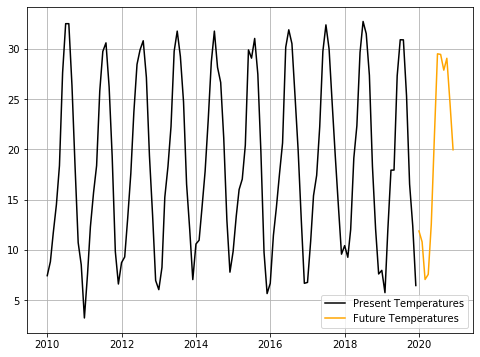

In [57]:
plt.figure(figsize=(8,6))
plt.plot(y_train,label = 'Present Temperatures',color='black')
plt.plot(Y_prediction,label='Future Temperatures',color='orange')
plt.legend(loc='best')
plt.grid(True)

***Conclusion:*** If the deforestration is continued we will be having ***highest average*** monthly temperature os ***29.5*** degreed for the month of July-2020
    

***References***

Dataset of Amazon deforestation - https://rainforests.mongabay.com/amazon/deforestation-rate.html

<br />
<center>
<img src =ipynb.images/team.gif width = 400 />
</center>